# Project work
  **Abstract:** In this porject work we are going to implement some state-of-the art clustering and applying some SVR or ANN techniques in order to predict some biological features.
 
  This dataset was received in ecological monitoring study in Moscow region. In details, the dataset assessed the soil quality around mineral waste storage in Voskresensk. Different chemical properties of soils presented in data set and Eco toxicological an bacterial community responses. Its interesting that the values of some chemical elements in soils closed to storage were much higher than in reference, but in Russia and other countries this parameters have no official limits due to its rareness 
  
  Furthermore, we are going to implement different regression models to predict values of soil chemical properties and we have planned do some clusting analysis using t-distributed Stochastic Neighbor Embedding and Principle Compoment Analysis (PCA).

  The structure of this project work is very simple, we are going see some parameters distributions, since then you are goin to see the support vector regressors with different kernels and hyperparameters, the project continues with the Fully connected Neural Networks namely Artificial Neural networks (ANN) we also tried verious types of neurons and layers and changes have been observed and reported in. Moving on You will see some data analysis and data cleaning in order to have a better prediction and in the end you will see clustring anaylsis, hope you enjoy our observations.

**Key words:** Ann, SVR, Soil chemical properties, prediction, Clustring analysis, Normalized toxicity parameters, Bacterial community (FISH method)


**Introduction:** As we know that, Soil chemical properties are the most important part in the agriculture and integrating machine learning with the analysis of the soil and other biological land features will increase the quality of plant growth and annual harversting day in and day out. For that purpose we are going to see modernized ML alorithms and see how these will predict our collected data and what future anaylsis would be done with it.

# Practical Part

In [1]:
# Important libraries to our project 
# For math operations
import numpy as np
# for loading and initial preprocessing of raw date
import pandas as pd
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
# main libs for data preparation and ML regression algorithms
from sklearn import datasets, linear_model
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# plotting of the results
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
# basic lib for NNs creation
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ds.csv to ds.csv


**Let's briefly see what the database consists**

In [0]:
df = pd.read_csv("ds.csv", error_bad_lines=False) #Reading the database

In [4]:
df.head(5)

Collection point  Label  pH (H2O)  ...  Acidobacteria  Bacteroidetes   Archaea
0               P1      1      8.88  ...      10.879345       5.337783  6.345340
1               P1      2      7.40  ...      10.579345       5.037783  6.045340
2               P1      3      5.92  ...      10.279345       4.737783  5.745340
3               P9      4      9.12  ...       6.903049       5.639226  3.585513
4               P9      5      7.60  ...       6.793049       5.529226  3.475513

[5 rows x 32 columns]

In [5]:
df.columns

Index(['Collection point', 'Label', 'pH (H2O)', 'EC', 'Organic C%',
       'NO3 mg/kg', 'P2O5 mg/kg', 'Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba', 'La',
       'Ce', 'F', 'SO4', 'Ca', 'Earthworms  Toxicity%',
       'S.alba  germination toxicity%', 'S.alba  root toxicity%',
       'S. quadricauda  toxicity%', 'C.affinis  toxicity%',
       'Alphaproteobacteria', 'Betaproteobacteria', '? Proteobacteria',
       'Deltaproteobacteria', 'Actinobacteria', 'Planctomycetales',
       'Acidobacteria', 'Bacteroidetes', 'Archaea'],
      dtype='object')

In [6]:
df.iloc[0:1, :]

Collection point  Label  pH (H2O)  ...  Acidobacteria  Bacteroidetes  Archaea
0               P1      1      8.88  ...      10.879345       5.337783  6.34534

[1 rows x 32 columns]

In [7]:
df.shape

(21, 32)

- We are going to train and report on SVR. Try out SVR for different kernels, hyper-parameters. Due to data is not that big, we are going to use 90% for training and only 10% for validation. For the optimal hyper-parameters we will use cross-validation and grid search.

Let's see Soil chemical properties' paramenters distribution

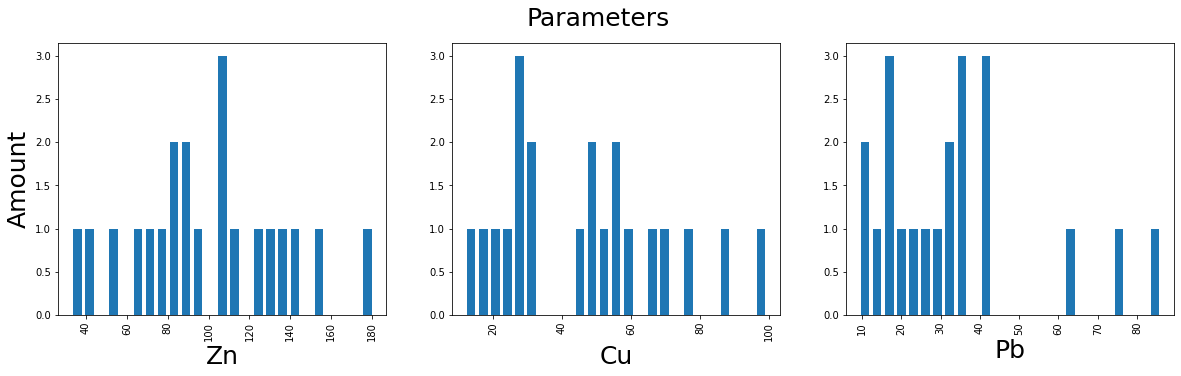

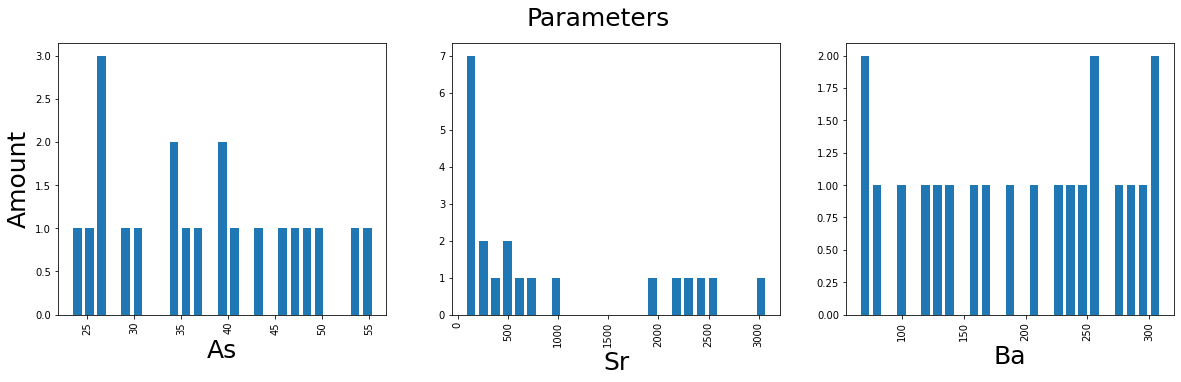

In [8]:
groups1 = ['Zn', 'Cu', 'Pb']

groups2 = ['As', 'Sr', 'Ba']

plt.figure(figsize=(20,5))

subplot_n = 1
for group in groups1:
    if group == groups1[1]:
        plt.ylabel('Amount',fontsize=25)
    hist, bins = np.histogram(df[group], bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot(1,len(groups1), subplot_n)
    plt.bar(center, hist, align='center', width=width)
    plt.xticks(rotation=90)
    plt.xlabel(group, fontsize=25)
    subplot_n += 1
plt.suptitle('Parameters',fontsize=25)
plt.show()

plt.figure(figsize=(20,5))
subplot_n = 1
for group in groups2:
    if group == groups2[1]:
        plt.ylabel('Amount',fontsize=25)
    hist, bins = np.histogram(df[group], bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot(1,len(groups2), subplot_n)
    plt.bar(center, hist, align='center', width=width)
    plt.xticks(rotation=90)
    plt.xlabel(group, fontsize=25)
    subplot_n += 1
plt.suptitle('Parameters',fontsize=25)
plt.show()

Preparing our data for Support Vector Regressor (SVR) algorithm

In [0]:
# Scaling of the data
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range = (-1,1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# Invert scaling of the train and val data
def invert_scale(scaler, X):
    array = np.array(X)
    array = array.reshape(1, len(X))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

x_traintemp=[]
y_traintemp=[]
x_testtemp=[]
y_testtemp=[]

# mean of roots length as a target parameter
# We are getting the all of the nine Bacterial community (FISH method), % in total as our target parameters 
data_mean = df[['Alphaproteobacteria', 'Betaproteobacteria', '? Proteobacteria', 'Deltaproteobacteria', 'Actinobacteria', 'Planctomycetales', 'Acidobacteria', 'Bacteroidetes', 'Archaea']].values
y_mean = []
y_median = []
for item in data_mean:
    y_mean.append(np.mean(item))
    y_median.append(np.median(item))


df_st = DataFrame(data=df[['Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba']].values, index=None,
                  columns=['Zn', 'Cu', 'Log(Pb)', 'Log(As)', 'Log(Sr)','Log(Ba)'])
df_st = pd.concat([df_st, DataFrame(data = y_mean, columns = ['Mean length'])], axis = 1)
df_st = pd.concat([df_st, DataFrame(data = y_median, columns = ['Median of length'])], axis = 1)

# Choosing of the regressors

x_temp = np.array(df[['Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba']].values)
y_temp = np.array(y_mean)

# Splitting dataset to train/test subsets

x_traintemp, x_testtemp, y_traintemp, y_testtemp = train_test_split(x_temp, y_temp, test_size=0.1, random_state=10)

x_train=np.array(x_traintemp)
y_train=np.array(y_traintemp)
x_test=np.array(x_testtemp)
y_test=np.array(y_testtemp)

In [0]:
#Scaling of the train/test subsets
scaler, train_scaled, test_scaled = scale(np.concatenate((x_train, y_train.reshape(len(y_train),1)), axis = 1),
np.concatenate((x_test, y_test.reshape(len(y_test),1)), axis = 1))
x_train_scaled_l = train_scaled[:, 0:-1]
y_train_scaled_l = train_scaled[:, -1:]
x_test_scaled_l = test_scaled[:, 0:-1]
y_test_scaled_l = test_scaled[:, -1:]

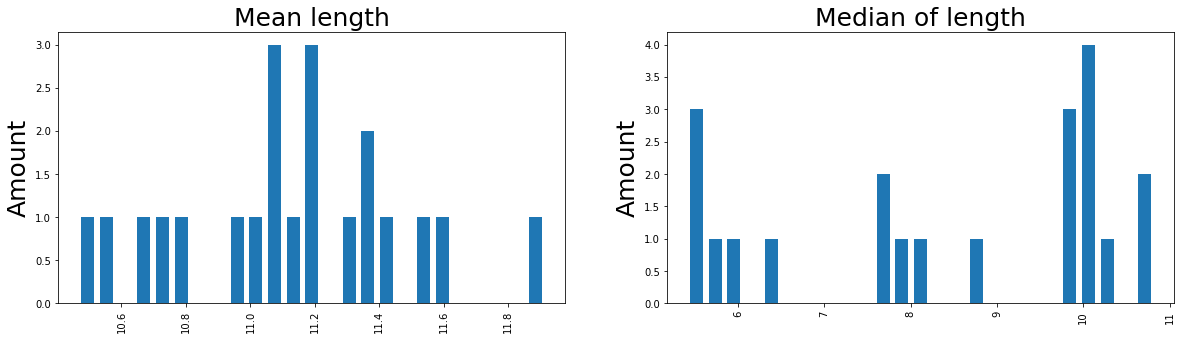

In [11]:
df_st.sample(n=10)

groups = ['Mean length', 'Median of length']

plt.figure(figsize=(20,5))

subplot_n = 1
for group in groups:
    hist, bins = np.histogram(df_st[group], bins=25)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.subplot(1,len(groups), subplot_n)
    plt.bar(center, hist, align='center', width=width)
    plt.xticks(rotation=90)
    plt.ylabel('Amount',fontsize=25)
    plt.title(group, fontsize=25)
    subplot_n += 1
plt.show()

**SVR Training with Grid Search hyperparameters & Poly kernel**

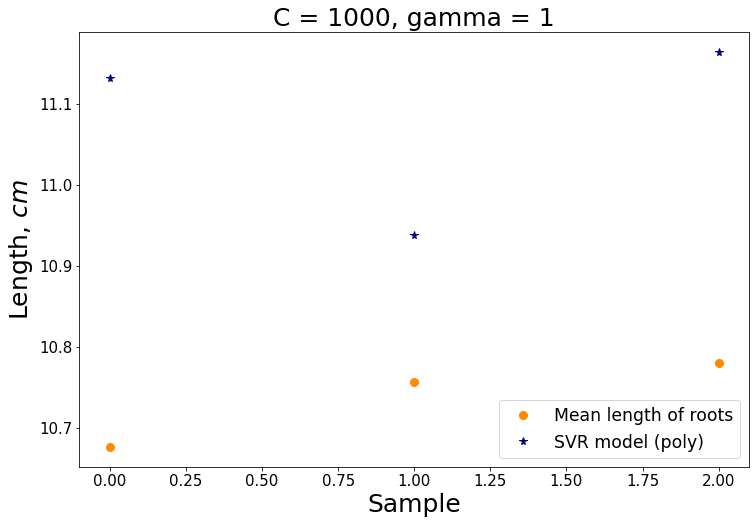

RMSE=0.36


In [12]:
# Hyperparameters selsction
"""Grid search optimal Hyperparameters are C = {10,100,1000} and gamma = {0.1,0.2,0.5,1.0}"""
#a regularization constant C below chosen based on grid search optimal Hyperparameter
item_C = 1000
# a kernel hyperparameter below is chosen based on grid search optimal Hyperparameter
item_gamma = 1

svr_poly = SVR(kernel='poly',  C=item_C, gamma=item_gamma) #We used poly kernel 

### try out other regressions
# svr_rbf = Ridge()

# svr_rbf = SVR(kernel='linear')

# svr_rbf = SVR(kernel='poly', degree = 2)


y_poly_scaled = svr_poly.fit(x_train_scaled_l, y_train_scaled_l.ravel()).predict(x_test_scaled_l)

inverted_test = scaler.inverse_transform(np.concatenate((x_test_scaled_l, y_test_scaled_l.reshape(len(y_test_scaled_l),1)), axis = 1))
inverted_result = scaler.inverse_transform(np.concatenate((x_test_scaled_l, y_poly_scaled.reshape(len(y_poly_scaled),1)), axis = 1)) 

y_test = inverted_test[:, -1:]
y_poly = inverted_result[:, -1:]

lw = 2

# sorting of the test data
index_for_sort = np.argsort(y_test, axis = 0)

y_test_sorted  = np.zeros(len(index_for_sort))
y_poly_sorted  = np.zeros(len(index_for_sort))
for i in range(0, len(index_for_sort)):
    y_test_sorted[i] = y_test[index_for_sort[i]]
    y_poly_sorted[i] = y_poly[index_for_sort[i]]

# plotting of the results
plt.figure(figsize = (12,8))
plt.plot(y_test_sorted, "o", color='darkorange', markersize=8,  label = 'Mean length of roots')
plt.plot(y_poly_sorted, "*", color='navy', markersize=8, lw = lw, label = 'SVR model (poly)')
plt.xlabel('Sample', fontsize=25)
plt.ylabel('Length, ${cm}$', fontsize=25)
plt.title('C = {0}, gamma = {1}'.format(item_C, item_gamma), fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
#plt.text(30, 10, 'RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_poly)), decimals = 2)),  fontsize=20, verticalalignment='top', bbox=props)
plt.legend(fontsize =  'xx-large')
#plt.tight_layout()
plt.show()
print('RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_poly)), decimals = 2)))

# SVR Training with different hyperparameter and linear kernel

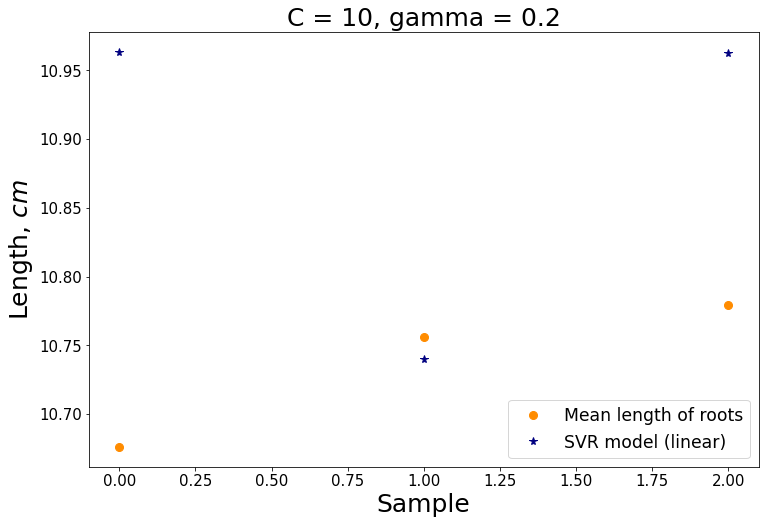

RMSE=0.2


In [13]:
# Hyperparameters selsction
"""Grid search optimal Hyperparameters are C = {10,100,1000} and gamma = {0.1,0.2,0.5,1.0}"""
#a regularization constant C below chosen based on grid search optimal Hyperparameter
item_C = 10
# a kernel hyperparameter below is chosen based on grid search optimal Hyperparameter
item_gamma = 0.2

svr_linear = SVR(kernel='linear',  C=item_C, gamma=item_gamma) #We used linear kernel 

### try out other regressions
# svr_rbf = Ridge()

# svr_rbf = SVR(kernel='linear')

# svr_rbf = SVR(kernel='poly', degree = 2)


y_linear_scaled = svr_linear.fit(x_train_scaled_l, y_train_scaled_l.ravel()).predict(x_test_scaled_l)

inverted_test = scaler.inverse_transform(np.concatenate((x_test_scaled_l, y_test_scaled_l.reshape(len(y_test_scaled_l),1)), axis = 1))
inverted_result = scaler.inverse_transform(np.concatenate((x_test_scaled_l, y_linear_scaled.reshape(len(y_linear_scaled),1)), axis = 1)) 

y_test = inverted_test[:, -1:]
y_linear = inverted_result[:, -1:]


lw = 2

# sorting of the test data
index_for_sort = np.argsort(y_test, axis = 0)

y_test_sorted  = np.zeros(len(index_for_sort))
y_linear_sorted  = np.zeros(len(index_for_sort))
for i in range(0, len(index_for_sort)):
    y_test_sorted[i] = y_test[index_for_sort[i]]
    y_linear_sorted[i] = y_linear[index_for_sort[i]]

# plotting of the results
plt.figure(figsize = (12,8))
plt.plot(y_test_sorted, "o", color='darkorange', markersize=8,  label = 'Mean length of roots')
plt.plot(y_linear_sorted, "*", color='navy', markersize=8, lw = lw, label = 'SVR model (linear)')
plt.xlabel('Sample', fontsize=25)
plt.ylabel('Length, ${cm}$', fontsize=25)
plt.title('C = {0}, gamma = {1}'.format(item_C, item_gamma), fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
#plt.text(30, 10, 'RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_linear)), decimals = 2)),  fontsize=20, verticalalignment='top', bbox=props)

plt.legend(fontsize =  'xx-large')
#plt.tight_layout()
plt.show()
print('RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_linear)), decimals = 2)))

**Fully Connected Neural Networks**

In [0]:
x_traintemp=[]
y_traintemp=[]
x_testtemp=[]
y_testtemp=[]

data_mean = df[['Alphaproteobacteria', 'Betaproteobacteria', '? Proteobacteria', 'Deltaproteobacteria', 'Actinobacteria', 'Planctomycetales', 'Acidobacteria', 'Bacteroidetes', 'Archaea']].values
y_mean = []
for item in data_mean:
      y_mean.append(np.mean(item))


x_temp = np.array(df[['Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba']].values)
y_temp = np.array(y_mean)

x_traintemp, x_testtemp, y_traintemp, y_testtemp = train_test_split(x_temp, y_temp, test_size=0.2, random_state=10)

x_train=np.array(x_traintemp)
y_train=np.array(y_traintemp)
x_test=np.array(x_testtemp)
y_test=np.array(y_testtemp)

# mean value
mean = x_train.mean(axis=0)
# standard daviation
std = x_train.std(axis=0)

x_train -= mean
x_train /= std
x_test -= mean
x_test /= std

**ANN with different 4 layers and 1024 neurons**

In [15]:
lw = 2
RMSE_err = list()
MAE_err = list()

# NN architecture     
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))


# Tuning of the optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


# training of the ANN
model.fit(x_train, y_train, epochs=50, batch_size=1 )

# evaluation of the trained model on the test set
mse, mae = model.evaluate(x_test, y_test)

RMSE_err.append(mse)
MAE_err.append(mae)

y_pred = model.predict(x_test)
print("Mean absolute error:", mae)
print("Mean squared error:", np.sqrt(mse))

index_for_sort = np.argsort(y_test, axis = 0)

y_test_sorted  = np.zeros(len(index_for_sort))
y_pred_sorted  = np.zeros(len(index_for_sort))
for i in range(0, len(index_for_sort)):
    y_test_sorted[i] = y_test[index_for_sort[i]]
    y_pred_sorted[i] = y_pred[index_for_sort[i]]
        
plt.show() 

Epoch 1/50
16/16 [==============================] - 0s 26ms/step - loss: 100.8590 - mae: 9.9668
Epoch 2/50
16/16 [==============================] - 0s 5ms/step - loss: 19.3076 - mae: 3.6850
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 17.7482 - mae: 3.3030
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 6.2070 - mae: 2.1439
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 4.3124 - mae: 1.6433
Epoch 6/50
16/16 [==============================] - 0s 6ms/step - loss: 3.6402 - mae: 1.6277
Epoch 7/50
16/16 [==============================] - 0s 6ms/step - loss: 1.4966 - mae: 1.0425
Epoch 8/50
16/16 [==============================] - 0s 6ms/step - loss: 1.0910 - mae: 0.9312
Epoch 9/50
16/16 [==============================] - 0s 6ms/step - loss: 0.5034 - mae: 0.5831
Epoch 10/50
16/16 [==============================] - 0s 6ms/step - loss: 0.2853 - mae: 0.4642
Epoch 11/50
16/16 [==============================] - 0s 6ms/step

Plotting of the results

RMSE=0.62


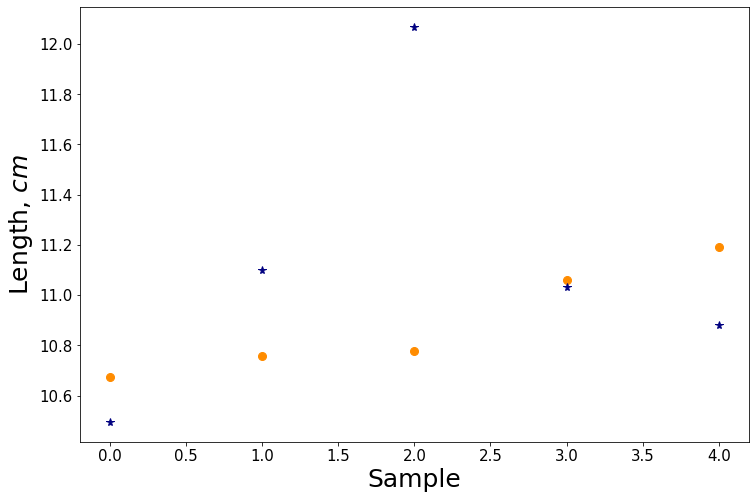

In [18]:
plt.figure(figsize = (12,8))
plt.plot(y_test_sorted, "o", color='darkorange', markersize=8,  label = 'Mean length of roots')
plt.plot(y_pred_sorted, "*", color='navy', markersize=8, lw = lw, label = 'NN model (Dense)')
plt.xlabel('Sample', fontsize=25)
plt.ylabel('Length, ${cm}$', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
#plt.text(30, 10, 'RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_pred)), decimals = 2)),  fontsize=20, verticalalignment='top', bbox=props)
#plt.legend(fontsize =  'xx-large')
#plt.tight_layout()
print('RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_pred)), decimals = 2)))

**ANN with different 5 layers and 4096 neurons**

In [19]:
lw = 2
RMSE_err = list()
MAE_err = list()


# NN architecture     
model = Sequential()
model.add(Dense(4096, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Tuning of the optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# training of the ANN
model.fit(x_train, y_train, epochs=50, batch_size=1 )

# evaluation of the trained model on the test set
mse, mae = model.evaluate(x_test, y_test)

RMSE_err.append(mse)
MAE_err.append(mae)

y_pred = model.predict(x_test)
print("Mean absolute error:", mae)
print("Mean squared error:", np.sqrt(mse))

index_for_sort = np.argsort(y_test, axis = 0)

y_test_sorted  = np.zeros(len(index_for_sort))
y_pred_sorted  = np.zeros(len(index_for_sort))
for i in range(0, len(index_for_sort)):
    y_test_sorted[i] = y_test[index_for_sort[i]]
    y_pred_sorted[i] = y_pred[index_for_sort[i]]
        
plt.show() 

Epoch 1/50
16/16 [==============================] - 1s 71ms/step - loss: 86.1342 - mae: 7.7003
Epoch 2/50
16/16 [==============================] - 1s 56ms/step - loss: 25.2840 - mae: 4.7101
Epoch 3/50
16/16 [==============================] - 1s 56ms/step - loss: 12.1477 - mae: 3.0705
Epoch 4/50
16/16 [==============================] - 1s 56ms/step - loss: 5.6580 - mae: 2.0646
Epoch 5/50
16/16 [==============================] - 1s 58ms/step - loss: 1.7781 - mae: 1.0231
Epoch 6/50
16/16 [==============================] - 1s 59ms/step - loss: 1.0354 - mae: 0.7365
Epoch 7/50
16/16 [==============================] - 1s 60ms/step - loss: 0.5164 - mae: 0.5858
Epoch 8/50
16/16 [==============================] - 1s 57ms/step - loss: 0.2737 - mae: 0.4231
Epoch 9/50
16/16 [==============================] - 1s 56ms/step - loss: 0.3102 - mae: 0.4397
Epoch 10/50
16/16 [==============================] - 1s 56ms/step - loss: 0.1872 - mae: 0.3377
Epoch 11/50
16/16 [==============================] - 1s 

RMSE=0.37


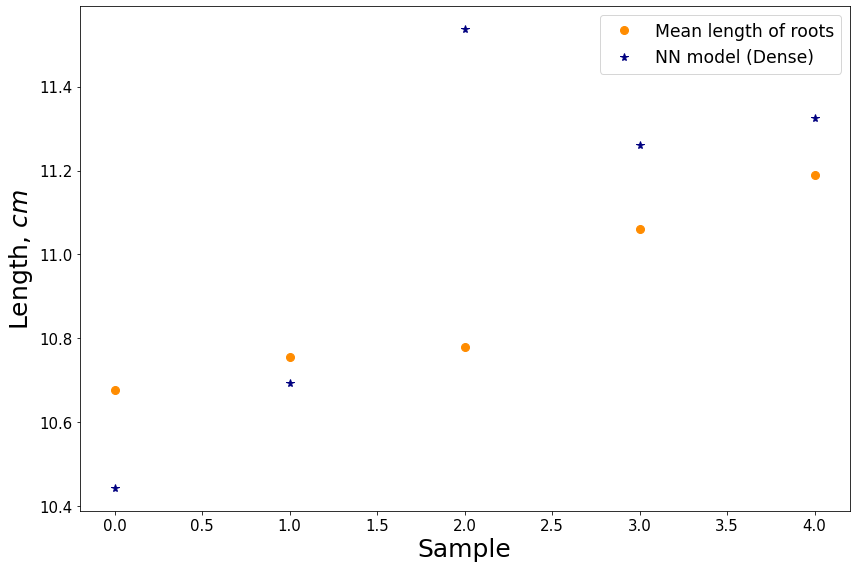

In [21]:
plt.figure(figsize = (12,8))
plt.plot(y_test_sorted, "o", color='darkorange', markersize=8,  label = 'Mean length of roots')
plt.plot(y_pred_sorted, "*", color='navy', markersize=8, lw = lw, label = 'NN model (Dense)')
plt.xlabel('Sample', fontsize=25)
plt.ylabel('Length, ${cm}$', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.1)
#plt.text(30, 10, 'RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_pred)), decimals = 2)),  fontsize=20, verticalalignment='top', bbox=props)
plt.legend(fontsize =  'xx-large')
plt.tight_layout()
print('RMSE={0}'.format(np.around(np.sqrt(mean_squared_error(y_test, y_pred)), decimals = 2)))

Display basic data statistics: Mean | Std | min | Max | quantile |

In [22]:
# Display basic data statistics
df.describe()

Label   pH (H2O)         EC  ...  Acidobacteria  Bacteroidetes    Archaea
count  21.000000  21.000000  21.000000  ...      21.000000      21.000000  21.000000
mean   11.000000   7.487619   1.342381  ...       7.291658       6.355319   7.408034
std     6.204837   1.433576   0.766700  ...       2.603594       1.696903   3.165156
min     1.000000   4.640000   0.256000  ...       4.361545       4.737783   3.365513
25%     6.000000   6.240000   0.820000  ...       4.899565       5.337783   5.745340
50%    11.000000   7.600000   1.020000  ...       6.683049       5.639226   7.171315
75%    16.000000   8.880000   1.940000  ...      10.279345       6.800569   7.951315
max    21.000000   9.600000   2.890000  ...      11.551648      10.116957  14.116957

[8 rows x 31 columns]

In [23]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
df.columns

Index(['Collection point', 'Label', 'pH (H2O)', 'EC', 'Organic C%',
       'NO3 mg/kg', 'P2O5 mg/kg', 'Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba', 'La',
       'Ce', 'F', 'SO4', 'Ca', 'Earthworms  Toxicity%',
       'S.alba  germination toxicity%', 'S.alba  root toxicity%',
       'S. quadricauda  toxicity%', 'C.affinis  toxicity%',
       'Alphaproteobacteria', 'Betaproteobacteria', '? Proteobacteria',
       'Deltaproteobacteria', 'Actinobacteria', 'Planctomycetales',
       'Acidobacteria', 'Bacteroidetes', 'Archaea'],
      dtype='object')

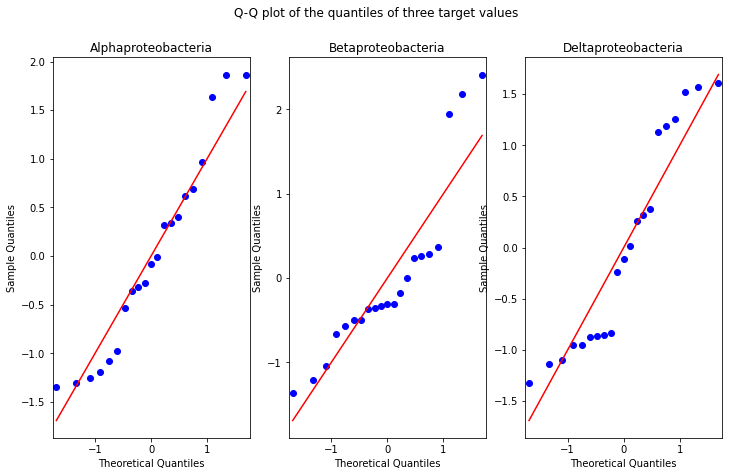

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,7))
fig.suptitle('Q-Q plot of the quantiles of three target values')
ax= axes.flatten()
sm.qqplot((df['Alphaproteobacteria']), fit = True, line='s', ax=ax[0])
ax[0].set_title('Alphaproteobacteria')
sm.qqplot((df['Betaproteobacteria']), fit = True, line='s', ax=ax[1])
ax[1].set_title('Betaproteobacteria')
sm.qqplot((df['Deltaproteobacteria']), fit = True, line='s', ax=ax[2])
ax[2].set_title('Deltaproteobacteria')
plt.show()

Text(0.5, 1.0, 'Deltaproteobacteria')

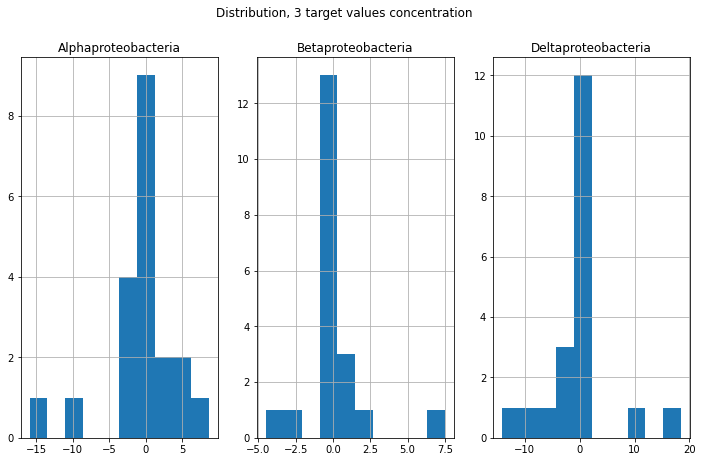

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,7))
fig.suptitle('Distribution, 3 target values concentration')
ax= axes.flatten()
df['Alphaproteobacteria'].diff().hist(ax=ax[0])
ax[0].set_title('Alphaproteobacteria')
df['Betaproteobacteria'].diff().hist(ax=ax[1])
ax[1].set_title('Betaproteobacteria')
df['Deltaproteobacteria'].diff().hist(ax=ax[2])
ax[2].set_title('Deltaproteobacteria')

In [27]:
#Null hypothesis: distribution is normal

# Shapiro-Wilk normality test
print('For Alphaproteobacteria in dataset  p =',stats.shapiro(df['Alphaproteobacteria'])[1])
print('For Betaproteobacteria in dataset p =', stats.shapiro(df['Betaproteobacteria'])[1])
print('For Deltaproteobacteria in dataset  p =',stats.shapiro(df['Deltaproteobacteria'])[1])

For Alphaproteobacteria in dataset  p = 0.15849919617176056
For Betaproteobacteria in dataset p = 0.0028636299539357424
For Deltaproteobacteria in dataset  p = 0.01624111831188202


In [28]:
# Anderson-Darling test 
print("Anderson-Darling statistics for Alphaproteobacteria:")
print(stats.anderson(df['Alphaproteobacteria'], dist='norm'))

print("Anderson-Darling statistics for Betaproteobacteria:")
print(stats.anderson(df['Betaproteobacteria'], dist='norm'))

print("Anderson-Darling statistics for Deltaproteobacteria:")
print(stats.anderson(df['Deltaproteobacteria'], dist='norm'))

Anderson-Darling statistics for Alphaproteobacteria:
AndersonResult(statistic=0.3804364935448561, critical_values=array([0.508, 0.579, 0.694, 0.81 , 0.963]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Anderson-Darling statistics for Betaproteobacteria:
AndersonResult(statistic=1.3790723323896898, critical_values=array([0.508, 0.579, 0.694, 0.81 , 0.963]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))
Anderson-Darling statistics for Deltaproteobacteria:
AndersonResult(statistic=0.90972833910417, critical_values=array([0.508, 0.579, 0.694, 0.81 , 0.963]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


Pearson corrolation 

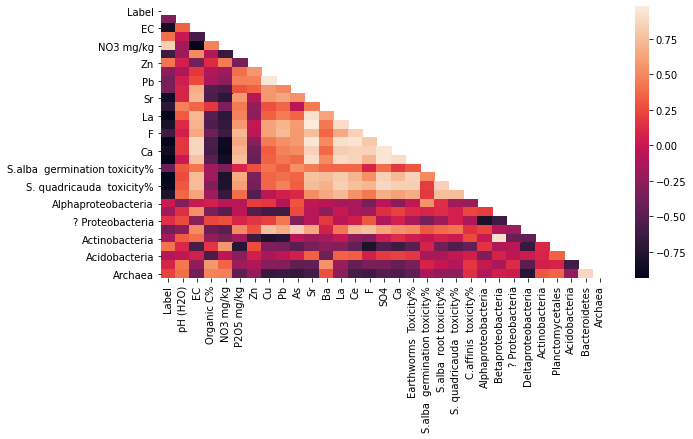

In [29]:
#corrolation of all features and target veriables
plt.figure(figsize=(10, 5))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), mask=matrix)

# Let's see Soil chemical properties | Features Distribution

Text(0, 0.5, 'Density')

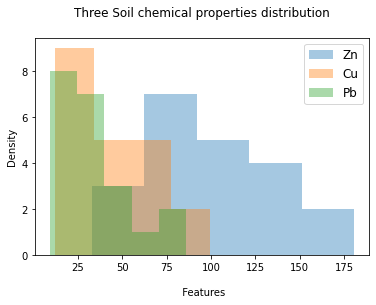

In [30]:
sns.distplot(df['Zn'],  kde=False, label='Zn')
sns.distplot(df['Cu'],  kde=False, label='Cu')
sns.distplot(df['Pb'],  kde=False, label='Pb')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Three Soil chemical properties distribution\n')
plt.xlabel('\n  Features ')
plt.ylabel('Density')

# Let's see all five distribution of normalized toxicity parameters, % vs control

Text(0, 0.5, 'Density')

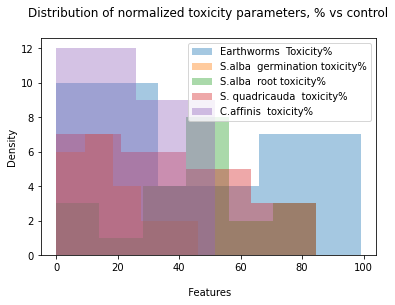

In [31]:
sns.distplot(df['Earthworms  Toxicity%'],  kde=False, label='Earthworms  Toxicity%')
sns.distplot(df['S.alba  germination toxicity%'],  kde=False, label='S.alba  germination toxicity%')
sns.distplot(df['S.alba  root toxicity%'],  kde=False, label='S.alba  root toxicity%')
sns.distplot(df['S. quadricauda  toxicity%'],  kde=False, label='S. quadricauda  toxicity%')
sns.distplot(df['C.affinis  toxicity%'],  kde=False, label='C.affinis  toxicity%')
# Plot formatting
plt.legend(prop={'size': 10})
plt.title('Distribution of normalized toxicity parameters, % vs control\n')
plt.xlabel('\n  Features ')
plt.ylabel('Density')

# Let's see three last Bacterial community (FISH method), % in total | Targets Distribution

Text(0, 0.5, 'Density')

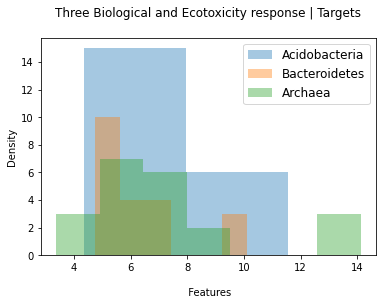

In [32]:
sns.distplot(df['Acidobacteria'],  kde=False, label='Acidobacteria')
sns.distplot(df['Bacteroidetes'],  kde=False, label='Bacteroidetes')
sns.distplot(df['Archaea'],  kde=False, label='Archaea')
# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Three Biological and Ecotoxicity response | Targets\n')
plt.xlabel('\n  Features ')
plt.ylabel('Density')

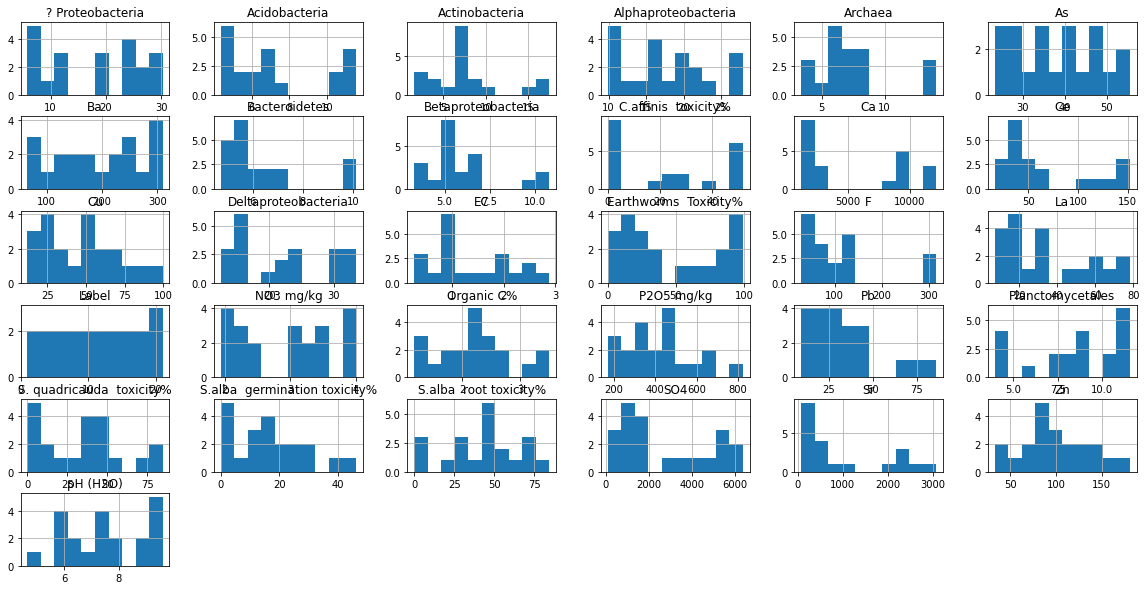

In [33]:
#overall distribution of the data base veriables can be seen below
df.hist(figsize=(20, 10));

**Regression algorithms for predicting target parameter(s)**

# Linear Regressions

In [0]:
#needed libraries
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

let's prededict Alphaproteobacteria target parameter based on Cu attribute

In [35]:
X = df['Cu'].values.reshape(-1,1)
y = df['Alphaproteobacteria'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[16.58248228]
[[0.02492797]]


Every for every unit of change in Ca, the change in Alphaproteobacteria target value is 0.02% respectively

In [37]:
y_pred_linear_reg = regressor.predict(X_test)
dt = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_linear_reg.flatten()})
dt

Actual  Predicted
0   15.87  16.881618
1   19.25  17.838852
2   10.11  17.245566

Not very close prediction | let's see the visualization below

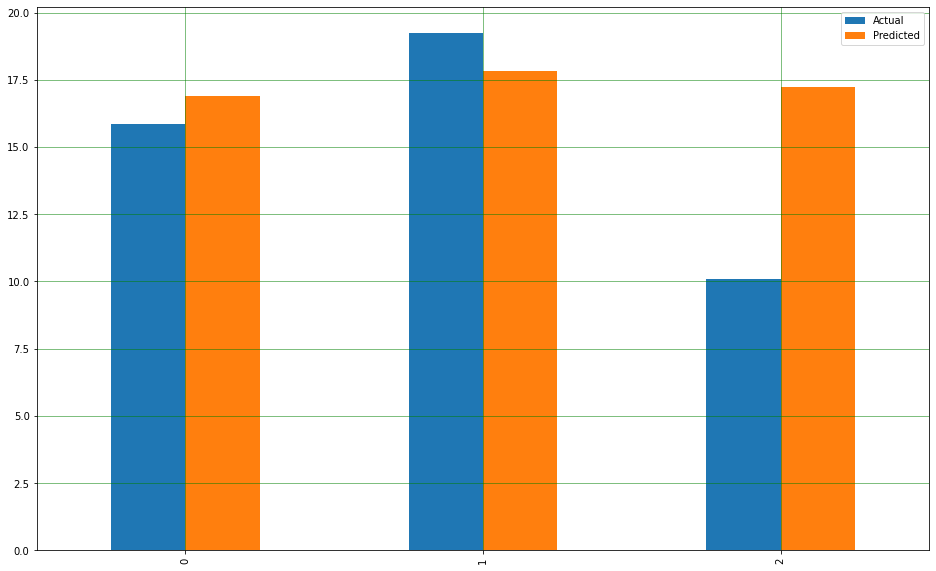

In [38]:
dt1 = dt.head(25)
dt1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [39]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_linear_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_linear_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear_reg)))

Mean Absolute Error: 3.1861107346431847
Mean Squared Error: 17.977005422911663
Root Mean Squared Error: 4.239929884197575


# Multiple Linear Regression

In [0]:
X = df[['Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba']].values #let's take many features
Y = df[['Alphaproteobacteria', 'Betaproteobacteria', '? Proteobacteria', 'Deltaproteobacteria', 'Actinobacteria', 'Planctomycetales', 'Acidobacteria', 'Bacteroidetes', 'Archaea']].values #All target values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred_multi_linear_reg = regressor.predict(X_test)

In [41]:
#actual values
y_test

array([[15.87      ,  9.89856574, 11.01458167, 20.20553785, 14.79545817,
         4.63609562,  6.39131474,  4.99689243,  6.39131474],
       [19.25      ,  5.28455285, 23.17073171, 14.02439024,  7.92682927,
        10.97560976,  4.47154472,  6.91056911,  7.5203252 ],
       [10.11      ,  5.36432494, 25.10045767, 15.67947368,  6.75498856,
        11.3316476 , 11.3316476 ,  5.15315789,  7.89915332]])

In [42]:
#predicted values accordingly 
y_pred_multi_linear_reg

array([[11.83787318,  9.25813822, 17.48084488, 17.8697789 , 15.34310656,
         7.10411455,  8.05908444,  5.84184883,  7.55651025],
       [15.64764262,  4.27324259, 24.53540083, 19.19379013,  4.87664602,
         8.2566674 ,  5.31051292,  7.39771136,  8.59362575],
       [11.76441382,  4.98747267, 24.35212399, 14.3070666 ,  7.65105382,
        11.06991297, 10.2621209 ,  4.64289152,  6.59973845]])

In [44]:
y_pred_linear_reg = regressor.predict(X_test)
dt = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred_linear_reg.flatten()})
dt

Actual  Predicted
0   15.870000  11.837873
1    9.898566   9.258138
2   11.014582  17.480845
3   20.205538  17.869779
4   14.795458  15.343107
5    4.636096   7.104115
6    6.391315   8.059084
7    4.996892   5.841849
8    6.391315   7.556510
9   19.250000  15.647643
10   5.284553   4.273243
11  23.170732  24.535401
12  14.024390  19.193790
13   7.926829   4.876646
14  10.975610   8.256667
15   4.471545   5.310513
16   6.910569   7.397711
17   7.520325   8.593626
18  10.110000  11.764414
19   5.364325   4.987473
20  25.100458  24.352124
21  15.679474  14.307067
22   6.754989   7.651054
23  11.331648  11.069913
24  11.331648  10.262121
25   5.153158   4.642892
26   7.899153   6.599738

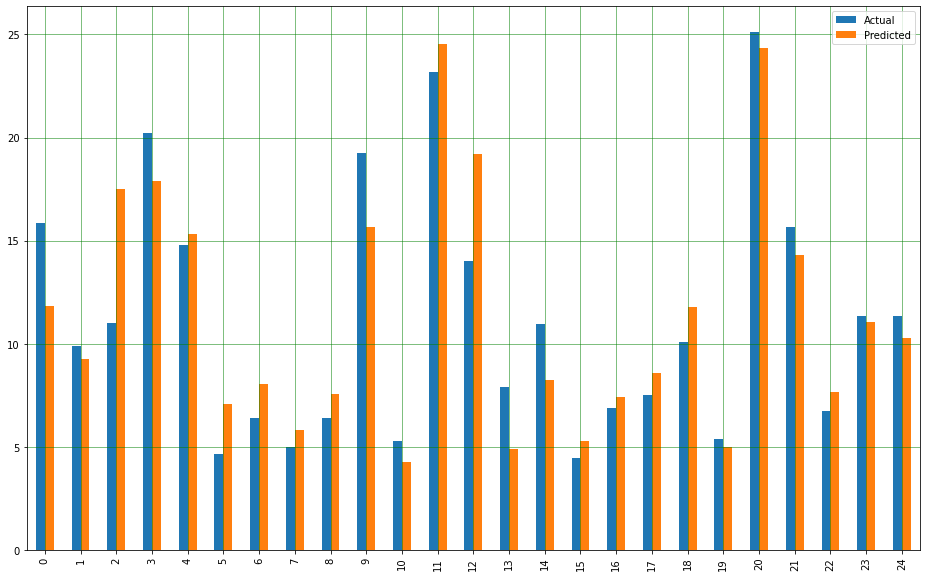

In [45]:
dt1 = dt.head(25)
dt1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

As we can see the multiple Linear Regression has performed not very good

In [46]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_multi_linear_reg))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_multi_linear_reg))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_multi_linear_reg)))

Mean Absolute Error: 1.7656834581744345
Mean Squared Error: 5.401540368937879
Root Mean Squared Error: 2.3241214187167327


`Conclusion:` We had studied linear regression. We implemented both simple linear regression and multiple linear regression with the help of the Scikit-Learn machine learning library and differenciated the results

# Ridge | Lasso | ElasticNet Regressions 

In [0]:
#Libraries
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [48]:
X = df[['Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba']].values #let's take many features
Y = df[['Alphaproteobacteria', 'Betaproteobacteria', '? Proteobacteria', 'Deltaproteobacteria', 'Actinobacteria', 'Planctomycetales', 'Acidobacteria', 'Bacteroidetes', 'Archaea']].values #All target values 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=40)
print(X_train.shape); print(X_test.shape)

(18, 6)
(3, 6)


# Ridge Regression

In [49]:
rr = Ridge(alpha=0.01)
#train scores
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print("Train RMSE:", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print("Train score:", r2_score(y_train, pred_train_rr))
#test scores
pred_test_rr= rr.predict(X_test)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print("Test score:",r2_score(y_test, pred_test_rr))

Train RMSE: 1.398566367749671
Train score: 0.9022738121848346
Test RMSE: 1.9656789630030689
Test score: 0.3016917207377719


In [50]:
dt = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': pred_test_rr.flatten()})
dt

Actual  Predicted
0   27.870000  27.655264
1    6.030151   6.328044
2    6.030151   6.069083
3   30.485762  29.242377
4    4.690117   5.481323
5    7.872697   8.645636
6    5.695142   5.896054
7    5.862647   5.663382
8    5.527638   5.231757
9   10.110000  11.884152
10   5.364325   5.087279
11  25.100458  23.051172
12  15.679474  15.871232
13   6.754989   7.223312
14  11.331648  10.153679
15  11.331648  10.190495
16   5.153158   4.343968
17   7.899153   6.272230
18  19.330000  15.197231
19   4.904553   4.384534
20  23.090732  23.074600
21  12.424390  19.517841
22   7.716829   4.950145
23  10.765610   7.542979
24   4.361545   5.673830
25   6.800569   6.412415
26   7.410325   7.410870

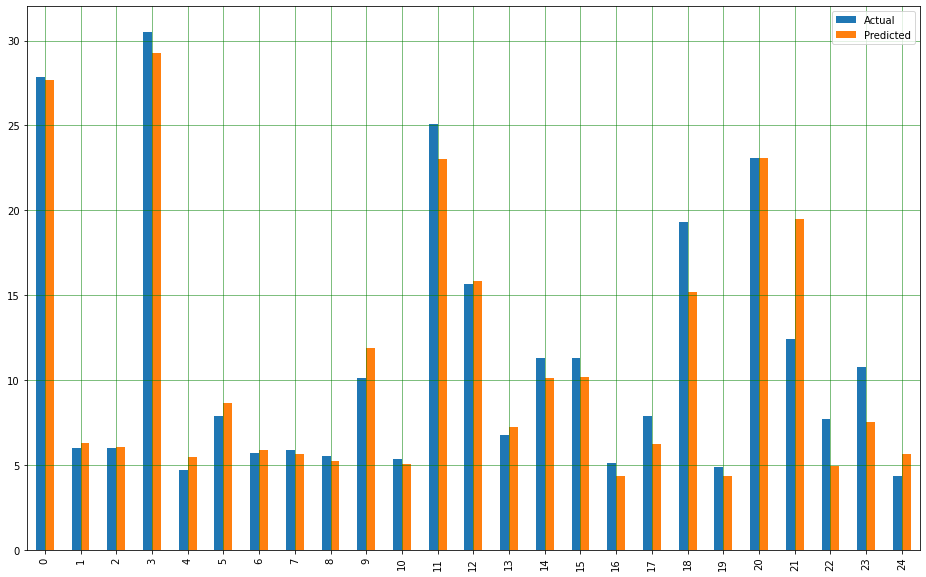

In [51]:
dt1 = dt.head(25)
dt1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Ridge regression has shown almost close prediction

# Lasso Regression

In [52]:
model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)
print("Train RMSE",np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
print("Train Score", r2_score(y_train, pred_train_lasso))

pred_test_lasso= model_lasso.predict(X_test)
print("Test RMSE", np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print("Test Score", r2_score(y_test, pred_test_lasso))

Train RMSE 1.3985699380893415
Train Score 0.902272939352014
Test RMSE 1.9662575058873053
Test Score 0.303581423339789


In [53]:
dt = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': pred_test_lasso.flatten()})
dt

Actual  Predicted
0   27.870000  27.647814
1    6.030151   6.326501
2    6.030151   6.076510
3   30.485762  29.234509
4    4.690117   5.487369
5    7.872697   8.646277
6    5.695142   5.903882
7    5.862647   5.661901
8    5.527638   5.231458
9   10.110000  11.890112
10   5.364325   5.092154
11  25.100458  23.045272
12  15.679474  15.875772
13   6.754989   7.225290
14  11.331648  10.150983
15  11.331648  10.184951
16   5.153158   4.349374
17   7.899153   6.270519
18  19.330000  15.199344
19   4.904553   4.387907
20  23.090732  23.072547
21  12.424390  19.518113
22   7.716829   4.953495
23  10.765610   7.542502
24   4.361545   5.673117
25   6.800569   6.417128
26   7.410325   7.410255

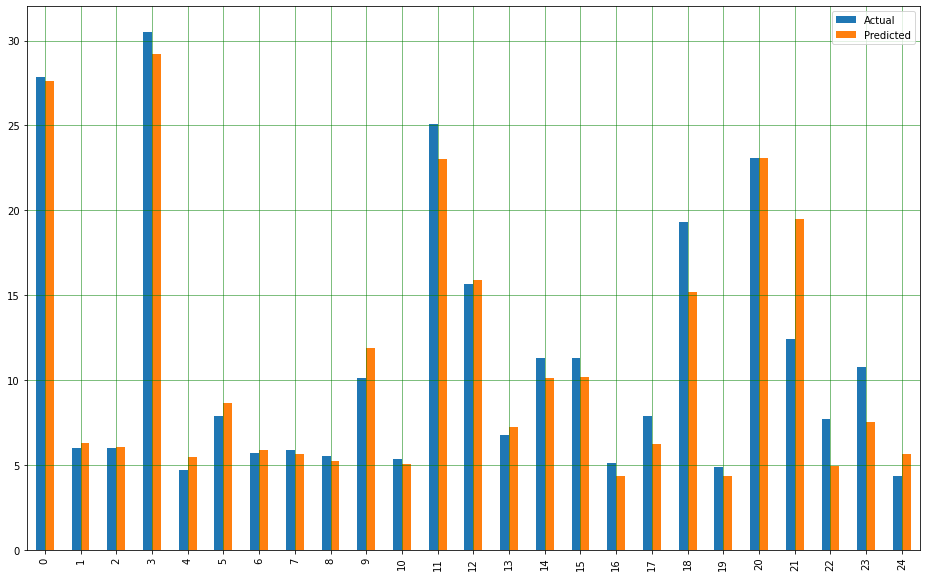

In [54]:
dt1 = dt.head(25)
dt1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

Lasso was as same as ridge regression

#ElasticNet Regression

In [55]:
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))
pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

1.398568084959016
0.902273510567993
1.9661212325463977
0.3027227546694873


In [56]:
dt = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': pred_test_enet.flatten()})
dt

Actual  Predicted
0   27.870000  27.648983
1    6.030151   6.327162
2    6.030151   6.076232
3   30.485762  29.237494
4    4.690117   5.484607
5    7.872697   8.645823
6    5.695142   5.900289
7    5.862647   5.662369
8    5.527638   5.231078
9   10.110000  11.887954
10   5.364325   5.090062
11  25.100458  23.046857
12  15.679474  15.874157
13   6.754989   7.224733
14  11.331648  10.152124
15  11.331648  10.187461
16   5.153158   4.346756
17   7.899153   6.271389
18  19.330000  15.197990
19   4.904553   4.386459
20  23.090732  23.073724
21  12.424390  19.518075
22   7.716829   4.952299
23  10.765610   7.542566
24   4.361545   5.673419
25   6.800569   6.414701
26   7.410325   7.410301

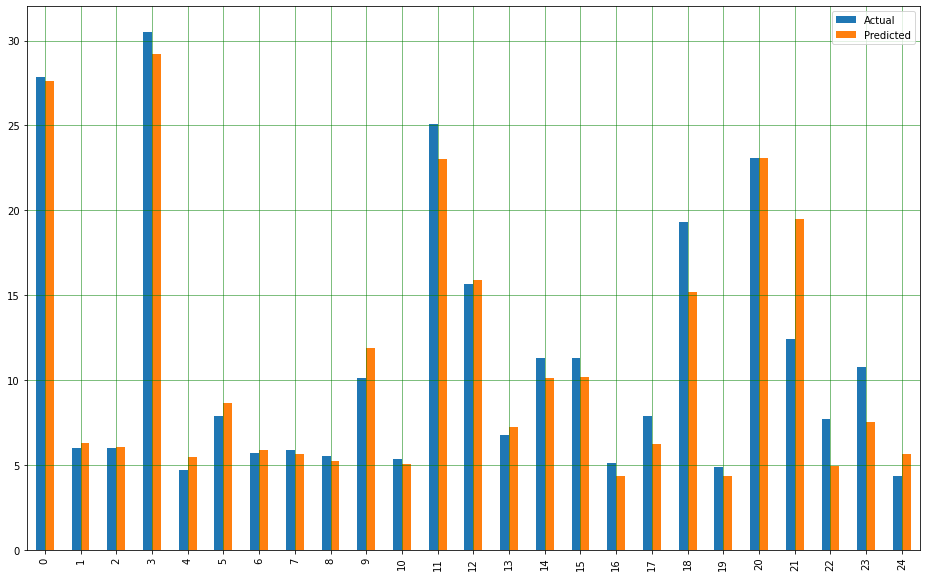

In [57]:
dt1 = dt.head(25)
dt1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# We are going to perform cluster analysis for regressors (t-SNE and PCA) and visualize clusters.

# t-distributed Stochastic Neighbor Embedding

In [0]:
from sklearn.manifold import TSNE
scaler=StandardScaler()
tsne = TSNE(n_components=2)
#Regressors
X = np.array(df[['Zn', 'Cu', 'Pb', 'As', 'Sr', 'Ba', 'La', 'Ce', 'F', 'SO4', 'Ca']].values)

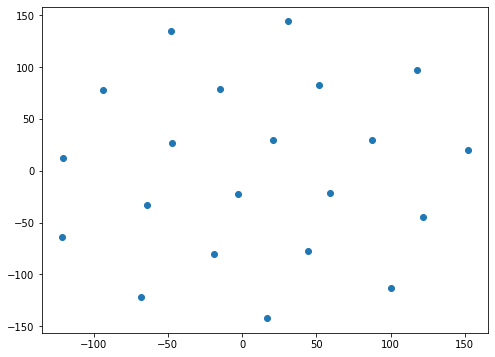

In [59]:
pred= tsne.fit_transform(scaler.fit_transform(X))
plt.figure(figsize=(8,6))
plt.scatter(pred[:,0],pred[:,1])

We have tried tsne method, after not satisifactory results we moved on with PCA

# Derive driving factors for Soil chemical properties | PCA (Principle Component Analysis)

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [0]:
Group = [str(var) for var in df.drop(['Collection point', 'Label'], axis=1).columns]

In [0]:
df = df.drop(['Collection point', 'Label'], axis=1)
scaler=StandardScaler()
scaler.fit(df)
scaled_data=scaler.transform(df)
pca=PCA(n_components=2)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)

In [63]:
print("Scaled values shape:", scaled_data.shape)
print("X_pca shape:", x_pca.shape)

Scaled values shape: (21, 30)
X_pca shape: (21, 2)


Text(0, 0.5, 'Second principle component')

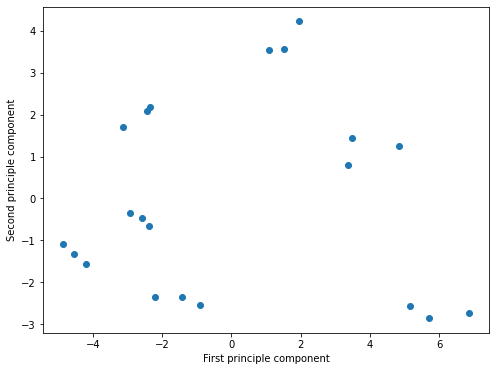

In [64]:
# Let's see the first and second components of our data
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

In [65]:
#find the co-variance matrix which is : A^T * A
sample_data = scaled_data
# matrix multiplication using numpy
covar_matrix = np.matmul(sample_data.T , sample_data)
print ( "The shape of covariance matrix = ", covar_matrix.shape)

The shape of covariance matrix =  (30, 30)


`Let's see the eigenvalues and eigenvectors below`

In [66]:
from scipy.linalg import eig
#Eigendecomposition of the standardized data based on the correlation matrix:
cov_mat = np.cov(sample_data.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 3.52605654e-02+0.00000000e+00j -1.61724568e-01+0.00000000e+00j
   2.17791310e-01+0.00000000e+00j  4.99007055e-02+0.00000000e+00j
   3.78450977e-01+0.00000000e+00j -4.71387483e-01+0.00000000e+00j
   1.19123480e-01+0.00000000e+00j -1.18188714e-01+0.00000000e+00j
  -5.12074387e-02+0.00000000e+00j  2.89513527e-01+0.00000000e+00j
   1.68250444e-01+0.00000000e+00j  2.18279922e-01+0.00000000e+00j
  -2.27525155e-01+0.00000000e+00j  8.71663004e-02+0.00000000e+00j
   2.12759467e-01+0.00000000e+00j -6.29358114e-02+0.00000000e+00j
  -1.21371150e-01+0.00000000e+00j -7.66408167e-02+0.00000000e+00j
   1.73311130e-01+0.00000000e+00j -3.33049180e-01+0.00000000e+00j
   1.07043233e-01+0.00000000e+00j  1.28840924e-01-3.60121952e-03j
   1.28840924e-01+3.60121952e-03j -1.06644622e-02+3.73832727e-03j
  -1.06644622e-02-3.73832727e-03j  1.58272535e-01-2.30676439e-03j
   1.58272535e-01+2.30676439e-03j  7.97481259e-02-3.51877756e-02j
   7.97481259e-02+3.51877756e-02j -8.58990485e-02+0.00000000e+

In [67]:
#Elements and 1st and 2nd compoment distribution respectively
pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=Group)

PC1       PC2
pH (H2O)                       0.035261  0.161725
EC                             0.236060  0.173814
Organic C%                    -0.145800 -0.038831
NO3 mg/kg                     -0.238384 -0.166542
P2O5 mg/kg                     0.198915 -0.016527
Zn                            -0.050893 -0.349357
Cu                             0.152215 -0.345977
Pb                             0.173981 -0.315965
As                             0.178898 -0.112141
Sr                             0.258618 -0.042604
Ba                             0.134170  0.093037
La                             0.241293  0.079441
Ce                             0.261084 -0.075585
F                              0.240377 -0.115804
SO4                            0.273281  0.052747
Ca                             0.260800  0.073600
Earthworms  Toxicity%          0.257052  0.080684
S.alba  germination toxicity%  0.107574 -0.007709
S.alba  root toxicity%         0.228179  0.120770
S. quadricauda  toxicity%      0.237608  0.098193
C.affinis  toxicity%           0.172116  0.241290
Alphaproteobacteria           -0.014633 -0.017686
Betaproteobacteria             0.019703  0.340816
? Proteobacteria              -0.014133 -0.169327
Deltaproteobacteria            0.199585 -0.214554
Actinobacteria                -0.022885  0.400012
Planctomycetales              -0.171103  0.008474
Acidobacteria                  0.033667 -0.002637
Bacteroidetes                 -0.105856  0.145341
Archaea                       -0.164391  0.233342

**Conclusion:** In this project we have tried several machine learning algorithms to get the better results and as we have observed the soil chemical properties, Normalized toxicity parameters, and Bacterial community (FISH method) can be analaysed with ml algorithms in order to have a efficient plant grow analysis as well as it enables us to observe each and every components elements and we could demonstrate our corresponding analysis.